In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('diabetes.csv')

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<Axes: >

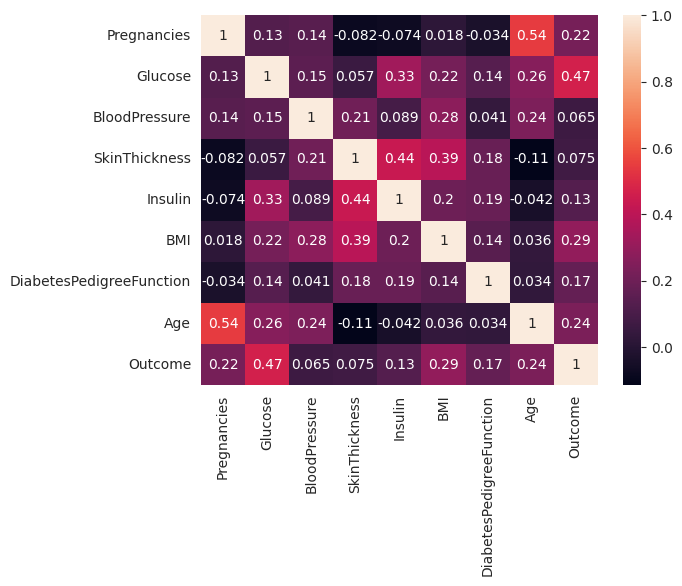

In [5]:
import seaborn as sns

sns.heatmap(data.corr(), annot=True)

In [6]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<Axes: xlabel='Outcome'>

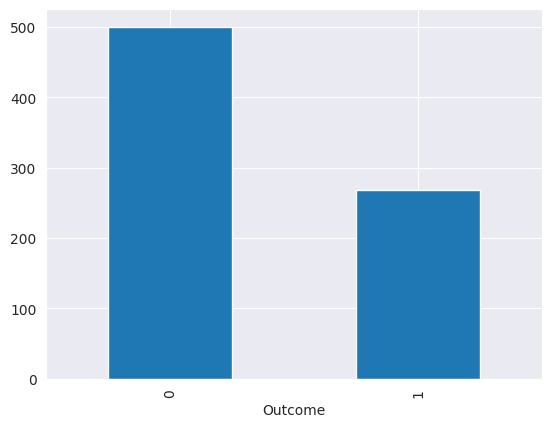

In [8]:
data['Outcome'].value_counts().plot(kind='bar')

In [ ]:
for col in data.columns:
    if col == 'Outcome':
        continue
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

In [135]:
def sigmoid(h):
    return 1. / (1 + np.exp(-h))


def log_loss(y_true, y_preds):
    y_preds = np.clip(y_preds, 1e-10, 1 - 1e-10)
    return -np.sum(y_true * np.log(y_preds) + (1 - y_true) * np.log(1 - y_preds))


def batch(x, y, bs):
    n = x.shape[0]
    for i in np.arange(0, n, bs):
        yield x[i:i + bs], y[i:i + bs]

In [136]:
class LogisticRegression(object):
    def __init__(self):
        self.weights = None

    def fit(self, x, y, epoches_n, lr, batch_size):
        n, k = x.shape

        if self.weights is None:
            self.weights = 0.001 * np.random.randn(k + 1)

        x_with_ones = np.concatenate((np.ones((n, 1)), x), axis=1)

        for i in range(epoches_n):
            for x_b, y_b in batch(x_with_ones, y, batch_size):
                predictions = sigmoid(x_b @ self.weights)
                self.weights -= lr * self.grad(x_b, y_b, predictions)

    def grad(self, x_b, y_b, predictions):
        grad_basic = x_b.T @ (predictions - y_b)
        return grad_basic

    def predict(self, x):
        n, k = x.shape
        x_with_ones = np.concatenate((np.ones((n, 1)), x), axis=1)
        return sigmoid(x_with_ones @ self.weights)

    def predict_values(self, x, threshold=0.5):
        return self.predict(x) >= threshold

In [137]:
from sklearn.model_selection import train_test_split

x = data.drop('Outcome', axis=1)
y = data['Outcome']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [138]:
import warnings

warnings.filterwarnings('ignore')


def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


lrs_to_try = [0.0001, 0.001, 0.01]
iter_n_to_try = [500, 1500, 2000]
batch_size_to_try = [1, 5, 10, 20, 30]

best_lr_iter_n = None

for lr in lrs_to_try:
    for iter_n in iter_n_to_try:
        for batch_size in batch_size_to_try:
            model = LogisticRegression()
            losses = model.fit(x_train, y_train, epoches_n=iter_n, lr=lr, batch_size=batch_size)
            y_pred = model.predict(x_test)
            y_pred = [1 if i > 0.5 else 0 for i in y_pred]
            acc = accuracy(y_test, y_pred)
            if best_lr_iter_n is None or best_lr_iter_n[0] < acc:
                best_lr_iter_n = [acc, lr, iter_n, batch_size, model]

            print(f'lr={lr}, iter_n={iter_n}, batch_size={batch_size}, acc={acc}')

print(
    f'best_model: lr={best_lr_iter_n[1]}, iter_n={best_lr_iter_n[2]}, batch_size={best_lr_iter_n[3]}, loss={best_lr_iter_n[0]}')

lr=0.0001, iter_n=500, batch_size=1, acc=0.7012987012987013
lr=0.0001, iter_n=500, batch_size=5, acc=0.6558441558441559
lr=0.0001, iter_n=500, batch_size=10, acc=0.6493506493506493
lr=0.0001, iter_n=500, batch_size=20, acc=0.6883116883116883
lr=0.0001, iter_n=500, batch_size=30, acc=0.6428571428571429
lr=0.0001, iter_n=1500, batch_size=1, acc=0.7077922077922078
lr=0.0001, iter_n=1500, batch_size=5, acc=0.6428571428571429
lr=0.0001, iter_n=1500, batch_size=10, acc=0.6493506493506493
lr=0.0001, iter_n=1500, batch_size=20, acc=0.6818181818181818
lr=0.0001, iter_n=1500, batch_size=30, acc=0.6428571428571429
lr=0.0001, iter_n=2000, batch_size=1, acc=0.7272727272727273
lr=0.0001, iter_n=2000, batch_size=5, acc=0.6428571428571429
lr=0.0001, iter_n=2000, batch_size=10, acc=0.6558441558441559
lr=0.0001, iter_n=2000, batch_size=20, acc=0.6883116883116883
lr=0.0001, iter_n=2000, batch_size=30, acc=0.6493506493506493
lr=0.001, iter_n=500, batch_size=1, acc=0.6558441558441559
lr=0.001, iter_n=500, 

In [139]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = best_lr_iter_n[4].predict_values(x_test, threshold=0.3)

print(f'accuracy_score={accuracy_score(y_test, y_pred)}')
print(f'precision_score={precision_score(y_test, y_pred)}')
print(f'recall_score={recall_score(y_test, y_pred)}')
print(f'f1_score={f1_score(y_test, y_pred)}')

accuracy_score=0.7337662337662337
precision_score=0.6842105263157895
recall_score=0.4727272727272727
f1_score=0.5591397849462365
